# Diet Data Editor

## Import Table from SQL

In [2]:
import sqlite3
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt

sql_connection = sqlite3.connect('diet.sqlite')
# Import desired table and set the index to id.
current_foods = pd.read_sql('SELECT * FROM may_2023', sql_connection, index_col='index')
current_foods.tail(10)

,food_id,date,meal_number,food_name,servings,carbs,fats,protein,calories
index,,,,,,,,,
214,1000216,2023-05-30 00:00:00,2,Eggs,4.0,0.0,5.0,6,70
215,1000217,2023-05-30 00:00:00,3,Rice,2.0,45.0,1.0,4,206
216,1000218,2023-05-30 00:00:00,3,Protein Powder,2.0,3.0,2.0,24,120
217,1000219,2023-05-30 00:00:00,3,Spicy Garlic,1.0,3.0,6.0,1,70
218,1000220,2023-05-30 00:00:00,3,Fruit Snacks,1.0,17.0,0.0,1,70
219,1000221,2023-05-30 00:00:00,4,Protein Powder,2.0,3.0,2.0,24,120
220,1000222,2023-05-30 00:00:00,4,Steak Ques.,1.0,42.0,27.0,26,520
221,1000223,2023-05-31 00:00:00,1,Oatmeal,2.0,32.0,3.0,9,160
222,1000224,2023-05-31 00:00:00,1,Protein Powder,2.0,3.0,2.0,24,120


In [3]:
current_foods.shape

(224, 9)

In [4]:
current_foods.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 224 entries, 0 to 223
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   food_id      224 non-null    int64  
 1   date         224 non-null    object 
 2   meal_number  224 non-null    int64  
 3   food_name    224 non-null    object 
 4   servings     224 non-null    float64
 5   carbs        224 non-null    float64
 6   fats         224 non-null    float64
 7   protein      224 non-null    int64  
 8   calories     224 non-null    int64  
dtypes: float64(3), int64(4), object(2)
memory usage: 17.5+ KB


In [5]:
current_foods[['carbs','fats','protein','calories']].describe()

,carbs,fats,protein,calories
count,224.000000,224.000000,224.000000,224.000000
mean,24.028571,7.167411,11.575893,204.522321
std,23.302354,10.785510,12.713947,176.234580
min,0.000000,0.000000,0.000000,45.000000
25%,3.000000,2.000000,1.000000,120.000000
50%,19.000000,2.000000,6.000000,130.000000
75%,41.250000,9.000000,24.000000,210.000000
max,111.000000,65.000000,88.000000,1332.000000


## Food Inserts List

In [15]:
# Set the current meal number to be logged
day_of_month = input("Enter the day of the month: DD")
date = f"2023-05-{day_of_month} 00:00:00"
choice = 1

while choice != 2:

    """ This algorithm takes a desired food input and then inserts it into a SQL query to
    retrieve the nutritional info for that food. The meal number and serving count are
     updated and then the entry is inserted into the dataframe. """

    # TODO: Add the food_db so that the algorithm can check for foods in the table.
    # TODO: Exception handling.

    db_food = input("What food would you like too add?")
    new_food = pd.read_sql("SELECT food_name, carbs, fats, protein, calories"
                            " FROM food_list "
                            " WHERE food_name = (?)", sql_connection, params=(db_food,))
    meal_number = int(input("Enter Meal Number: "))
    servings = float(input("Enter Serving Count: "))
    f_id = current_foods.iloc[-1, 0] + 1
    new_entry = [f_id,
                 date,
                 meal_number,
                 new_food.loc[0,'food_name'],
                 servings,
                 new_food.loc[0,'carbs'],
                 new_food.loc[0,'fats'],
                 new_food.loc[0,'protein'],
                 new_food.loc[0,'calories']]
    current_foods.loc[len(current_foods)] = new_entry
    choice = int(input("Add another? [1]Yes [2]No"))

current_foods['date'] = pd.to_datetime(current_foods['date'])
updated_foods = current_foods
updated_foods.tail()

,food_id,date,meal_number,food_name,servings,carbs,fats,protein,calories
index,,,,,,,,,
227,1000229,2023-05-31,3,Kirkland Sport,2.0,38.0,0.0,0,150
228,1000230,2023-05-31,3,Rice Krispie,2.0,17.0,2.0,0,90
229,1000231,2023-05-31,3,Protein Powder,2.0,3.0,2.0,24,120
230,1000232,2023-05-31,4,Ice Cream,3.0,23.0,9.0,3,180
231,1000233,2023-05-31,4,Protein Powder,2.0,3.0,2.0,24,120


## Data Manipulation

In [ ]:
# Update item(s) by index and column
# current_foods.loc[227,'servings'] = 2.0

# Drop operation
# current_foods.drop(index=current_foods.index[-1], axis=0, inplace=True) # Remove last entry

updated_foods.tail()

## Update SQL

In [16]:
# Export new chart to database with a date stamp
updated_foods.to_sql('may_2023', sql_connection, if_exists='replace')

# TODO: MANUALLY REVIEW SQL AND EXPORT NEW TABLE TO CSV AS BACKUP!!

232

## Today's Data

In [17]:
# Sort entries by date
mask = updated_foods['date'] == '2023-05-31 00:00:00'
today = updated_foods[mask]
today

,food_id,date,meal_number,food_name,servings,carbs,fats,protein,calories
index,,,,,,,,,
221,1000223,2023-05-31,1,Oatmeal,2.0,32.0,3.0,9,160
222,1000224,2023-05-31,1,Protein Powder,2.0,3.0,2.0,24,120
223,1000225,2023-05-31,1,Fruit Snacks,1.0,17.0,0.0,1,70
224,1000226,2023-05-31,2,JJ Turkey Tom 8in,1.0,57.0,20.0,25,505
225,1000227,2023-05-31,2,20oz Sprite,1.0,64.0,0.0,0,240
226,1000228,2023-05-31,2,Cheetos 1oz,1.0,15.0,10.0,2,160
227,1000229,2023-05-31,3,Kirkland Sport,2.0,38.0,0.0,0,150
228,1000230,2023-05-31,3,Rice Krispie,2.0,17.0,2.0,0,90
229,1000231,2023-05-31,3,Protein Powder,2.0,3.0,2.0,24,120


## Macro Calculations and Visualizations

In [18]:
# Calculate macronutrient totals based on serving count
total_carbs = int((today['carbs'] * today['servings']).sum())
total_fats = int((today['fats'] * today['servings']).sum())
total_protein = int((today['protein'] * today['servings']).sum())
total_cals = int((today['calories'] * today['servings']).sum())

print(f"Carbs: {total_carbs} | Goals: 500 400 300")
print(f"Fats: {total_fats} | Goals: 100 75 50")
print(f"Protein: {total_protein} | Goal: 200")
print(f"Calories: {total_cals}")

Carbs: 414 | Goals: 500 400 300
Fats: 79 | Goals: 100 75 50
Protein: 199 | Goal: 200
Calories: 3035


In [19]:
# Calculate the number of calories from each macro nutrient.
carb_cals = total_carbs * 4
fat_cals = total_fats * 9
protein_cals = total_protein * 4

print(f"Calories Form Carbs: {carb_cals}")
print(f"Calories Form Fats: {fat_cals}")
print(f"Calories Form Protein: {protein_cals}")

Calories Form Carbs: 1656
Calories Form Fats: 711
Calories Form Protein: 796


<Axes: ylabel='Macro Breakdown'>

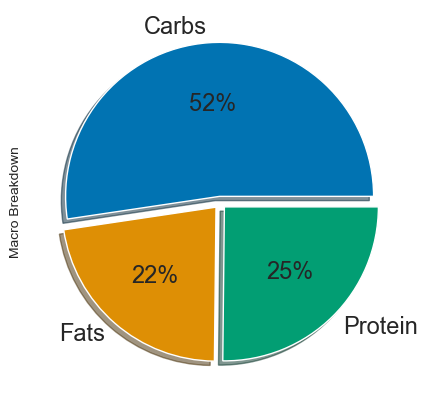

In [20]:
# Plot as a pie chart
macro_series = pd.Series(
    [carb_cals, fat_cals, protein_cals],
    index=['Carbs', 'Fats', 'Protein'],
    name="Macro Breakdown"
)

macro_series.plot.pie(
    colors=sns.color_palette('colorblind'),
    autopct='%1.0f%%',
    fontsize=17,
    shadow=True,
    explode=(0.04,0.04,0.04),
    figsize=(5,5)
)

In [24]:
# Add a total calories column
today.loc[:,'total_food_cals'] = today.loc[:,'servings'] * today.loc[:,'calories'] # Combine columns
today

/var/folders/6l/g3r9cy7524bc08xq768fxvq40000gn/T/ipykernel_8731/10959325.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  today.loc[:,'total_food_cals'] = today.loc[:,'servings'] * today.loc[:,'calories'] # Combine columns


,food_id,date,meal_number,food_name,servings,carbs,fats,protein,calories,total_food_cals
index,,,,,,,,,,
221,1000223,2023-05-31,1,Oatmeal,2.0,32.0,3.0,9,160,320.0
222,1000224,2023-05-31,1,Protein Powder,2.0,3.0,2.0,24,120,240.0
223,1000225,2023-05-31,1,Fruit Snacks,1.0,17.0,0.0,1,70,70.0
224,1000226,2023-05-31,2,JJ Turkey Tom 8in,1.0,57.0,20.0,25,505,505.0
225,1000227,2023-05-31,2,20oz Sprite,1.0,64.0,0.0,0,240,240.0
226,1000228,2023-05-31,2,Cheetos 1oz,1.0,15.0,10.0,2,160,160.0
227,1000229,2023-05-31,3,Kirkland Sport,2.0,38.0,0.0,0,150,300.0
228,1000230,2023-05-31,3,Rice Krispie,2.0,17.0,2.0,0,90,180.0
229,1000231,2023-05-31,3,Protein Powder,2.0,3.0,2.0,24,120,240.0


In [25]:
# Calories per meal
# Aggregate rows with the same meal number
cals_per_meal = today.groupby(today['meal_number']).aggregate({'total_food_cals': 'sum'})
cals_per_meal

,total_food_cals
meal_number,
1,630.0
2,905.0
3,720.0
4,780.0


<Axes: title={'center': 'Calories Per Meal'}, xlabel='Meal Number', ylabel='Calorie Count'>

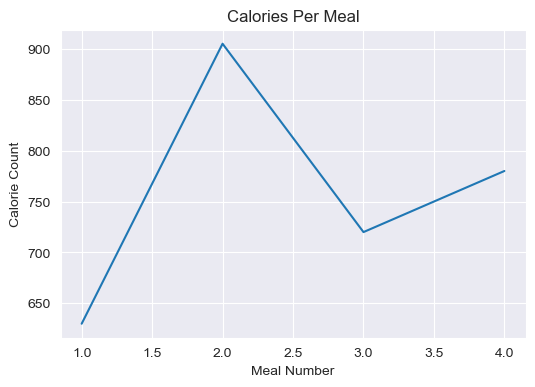

In [26]:
# Plot calories per meal
# Dimensions of the figure frame
plt.figure(figsize=(6,4))
plt.title("Calories Per Meal")
plt.xlabel("Meal Number")
plt.ylabel("Calorie Count")

sns.lineplot(
    data=cals_per_meal,
    legend=False
)

## LOG:
### 2023-05-15: Wine removed from diet
### 2023-05-29: New Cal Goals 500 400 300